In [2]:
## Import Libraries

import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore',category=DeprecationWarning)

# File management
import os
from tensorflow.keras.utils import image_dataset_from_directory

# Import relevant libraries
import PIL
from PIL import Image
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report,confusion_matrix

from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.layers import Rescaling
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
import pydot
from IPython.display import SVG

%matplotlib inline

2023-01-17 20:17:35.082292: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Obtain the dataset 
Considering the size of the dataset, we will remotely obtain the dataset, from kaggle repository.

[Intel Image Classification](https://www.kaggle.com/datasets/puneet6060/intel-image-classification)

## Get data

In [3]:
repository_dir = os.getcwd()

data_dir = os.path.join(repository_dir, "dataset")

# load variables
validation_percentage = 0.2
label_mode = "categorical"
# original size
img_size = (150, 150)
color_mode='rgb'
batch_size=1

dataset = image_dataset_from_directory(
    data_dir,
    batch_size=batch_size,
    label_mode=label_mode,
    color_mode=color_mode,
    image_size=img_size,
    shuffle=True,
)

classes = dataset.class_names
print(classes)

print(f"ds size: {dataset.cardinality()}")

Found 17034 files belonging to 6 classes.
['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
ds size: 17034


2023-01-17 20:17:40.390833: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-17 20:17:40.397539: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [12]:
# split the data to improve debug performance
dataset.shuffle(dataset.cardinality())
dataset = dataset.shard(num_shards=2, index=0)
print(dataset.cardinality())

tf.Tensor(8517, shape=(), dtype=int64)


## Visualize data

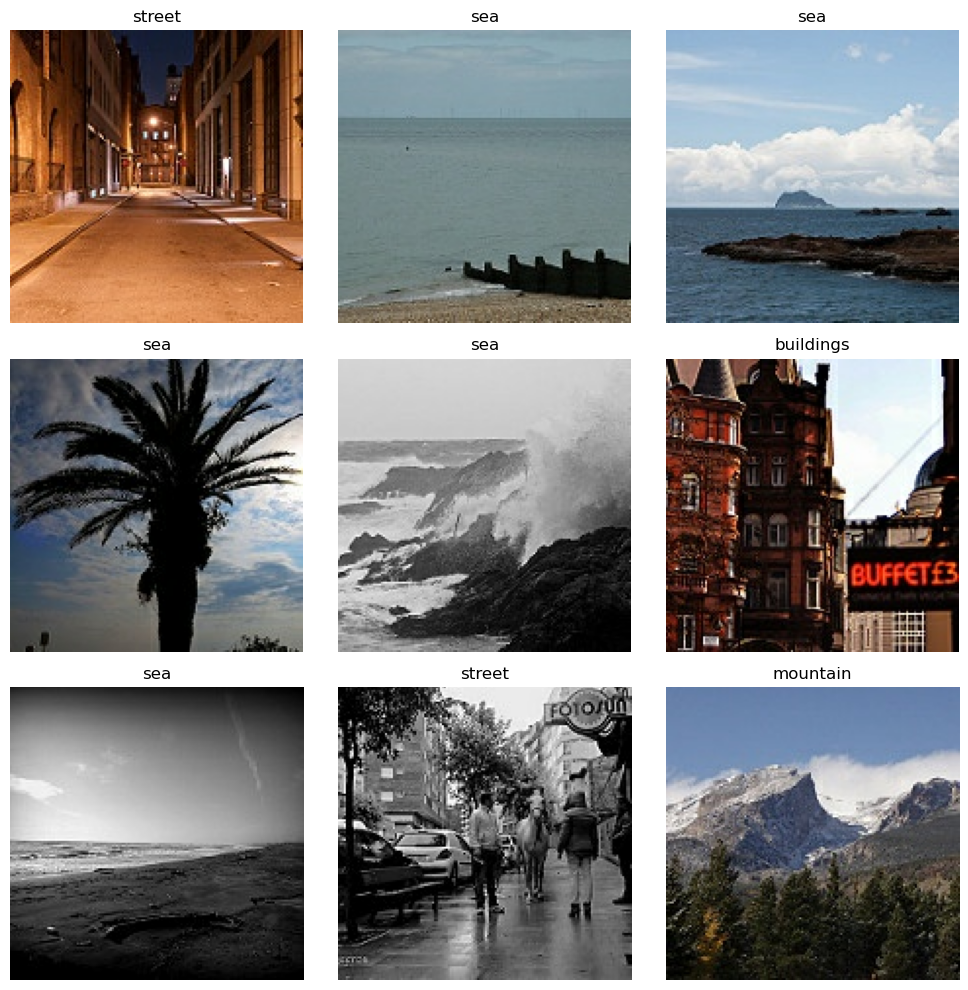

In [22]:
# from https://www.tensorflow.org/tutorials/load_data/images
fig, axes = plt.subplots(3, 3, figsize=(10,10))
axes = axes.flatten()
it = iter(dataset)

for i in range(9):    
    elem = it.get_next()
    image = elem[0].numpy()[0].astype("uint8")
    label = np.argmax(elem[1].numpy())
    
    ax = axes[i]
    ax.imshow(image)
    ax.set_title(classes[label])
    ax.axis('off')
plt.tight_layout()
plt.show()

[4 2 5 ... 1 4 3]


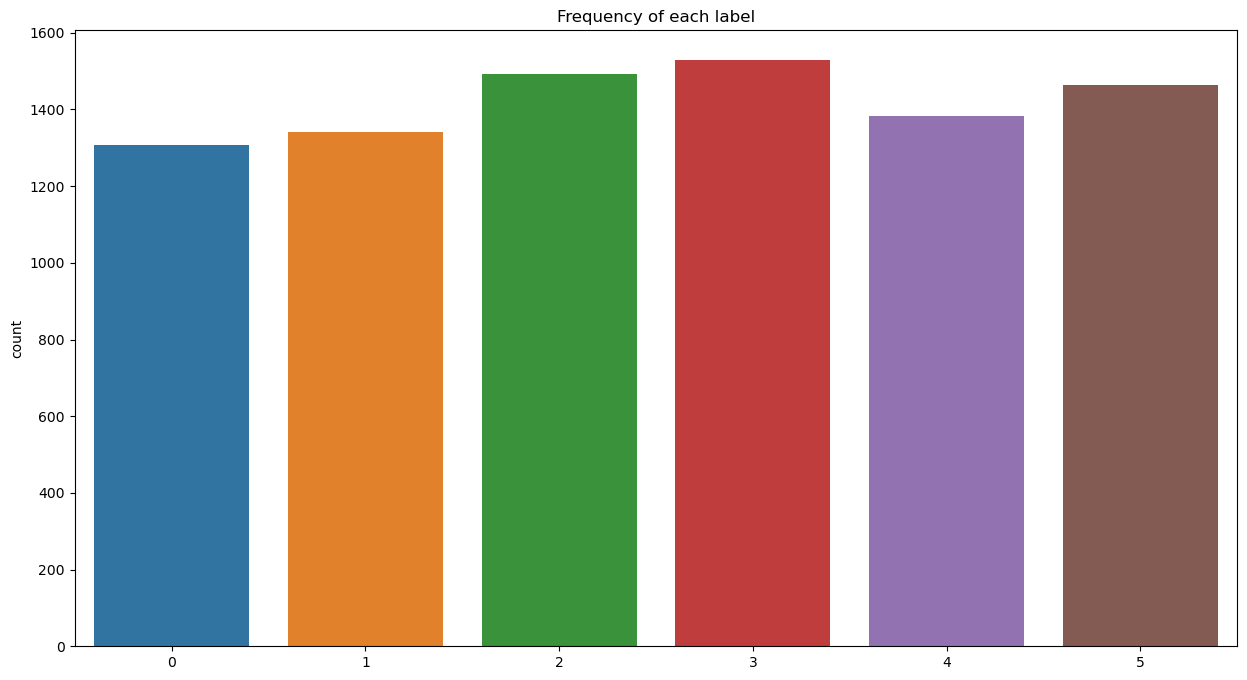

In [26]:
# Return a np array of labels index, by integer
def getArrayLabels(dataset):
    outputs = dataset.map(lambda x,y: y)
    tmp = [np.argmax(y) for y in outputs.as_numpy_iterator()]
    return np.asarray(tmp)

labels = getArrayLabels(dataset)
print(labels)
plt.figure(figsize = (15,8))
sns.countplot(labels)
plt.title("Frequency of each label")
plt.show()

In [30]:
# split data
# https://towardsdatascience.com/how-to-split-a-tensorflow-dataset-into-train-validation-and-test-sets-526c8dd29438
def get_dataset_partitions_tf(dataset, train_split=0.6, val_split=0.2, test_split=0.2):
    assert (train_split + test_split + val_split) == 1
    
    size = dataset.cardinality().numpy()
    print(size)
    
    # Specify seed to always have the same split distribution between runs
    dataset = dataset.shuffle(size, seed=12)
    
    train_size = int(train_split * size)
    val_size   = int(val_split * size)
    
    train_ds = dataset.take(train_size)   
    val_ds = dataset.skip(train_size).take(val_size)
    test_ds = dataset.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)
print(f"train size: {train_ds.cardinality().numpy()}")
print(f"val size: {val_ds.cardinality().numpy()}")
print(f"test size: {test_ds.cardinality().numpy()}")

8517
train size: 5110
val size: 1703
test size: 1704


### Get input image size

In [31]:
def getImageSize(dataset):
    elem = iter(dataset).get_next()
    print(elem)
getImageSize(train_ds)

2023-01-17 22:04:41.016226: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 5864 of 8517
2023-01-17 22:04:45.193224: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


InvalidArgumentError: {{function_node __wrapped__DatasetToSingleElement_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} Dataset had more than one element. [Op:DatasetToSingleElement]

## Model number 01
Our first thought was to use a pre-trained VGG16 model, but the model was to "heavy" for our dataset and our scope. we decided then to use the basic model of [Tensorflow documentation](https://www.tensorflow.org/tutorials/load_data/images]).

## Create model
No complex data augmentation.
rescaling = 1.0/255<br>
input_size=(150,150,3)

```
scale = 1.0/255
#Unvariable, considering the data phenomenum
loss = "sparse_categorical_crossentropy"
# Variable
optimizer = "adam"

# Define the input placeholder as a tensor with shape input_shape. 
# Think of this as an input image.
X_input = Input(input_size)
    
# Rescale image to range [0,1]
X = Rescaling(scale)(X_input)
    
# Conv01
X = Conv2D(32, (3, 3), activation='relu', name = 'conv01')(X)
X = MaxPooling2D((2, 2), name='max_pool01')(X)
    
# Conv02
X = Conv2D(32, (3, 3), activation='relu', name = 'conv02')(X)
X = MaxPooling2D((2, 2), name='max_pool02')(X)
    
# Conv03
X = Conv2D(32, (3, 3), activation='relu', name = 'conv03')(X)
X = MaxPooling2D((2, 2), name='max_pool03')(X)
    
#Flatten
X = Flatten()(X)
    
#FC01
X = Dense(128, activation='relu', name = 'FC01')(X)
    
#FC02
X = Dense(len(classes), name = 'FC02')(X)
    
model01 = Model(inputs = X_input, outputs = X)
model01.compile(
    optimizer=optimizer, 
    loss=loss,
    metrics=["accuracy"]
)

model01.summary()

#fit data

# variable
shuffle=True
# Considering the training size
epochs=20
batch_size = 500

model01.fit(
    data_train,
    validation_data=data_val,
    epochs=epochs,
    shuffle=shuffle,
    batch_size=batch_size
)
```

## Conclusions
**NOTE**: Partial conclusion

I choose to go with the training until the 3th epoch because it was taking to much time.<br>
The number of parameters of this model: 1,204,038<br>
To high for a proper performance. <br>
I was checking some other models that were working in the same goal, and one of them decide to go from the original size( [150,150] ) to [80, 80].<br> 
https://www.kaggle.com/code/robertocarlosmendoza/cnn-model-accuracy-95-recall-87 <br>
Besides the time, the metrics were not changing at all:<br>
accuracy: 0.1792<br>
loss: 1.7919<br>
val_loss: 1.7918<br>

VGG16 was a deep model, which in this scope we will not explore, but it has the feature to increase the number of filters per convolutional layer, in order to probably increase feature discrimination, at the same time that keeping parameters in a small scope.<br>

We will keep model01 here for documentation purposes.


## Model 02
images are resized to (80, 80), the number of filters increase per conv layer and batch size will also be increased.

In [ ]:
# resize images
new_size = [80, 80]
def resizeImage(image):
    image = tf.image.resize(
        image, 
        new_size,
        method=tf.image.ResizeMethod.BILINEAR,
    )
    return image

data_train02 = data_train.map(lambda x,y: (resizeImage(x),y) )
data_val02 = data_val.map(lambda x,y: (resizeImage(x),y) )
data_test02 = data_test.map(lambda x,y: (resizeImage(x),y) )

input_size = None
for image, _ in data_train02.take(1).as_numpy_iterator():
    input_size = image.shape[1:]
    break
print(input_size)

In [ ]:
scale = 1.0/255
#Unvariable, considering the data phenomenum
loss = "sparse_categorical_crossentropy"
# Variable
optimizer = "adam"

# Define the input placeholder as a tensor with shape input_shape. 
# Think of this as an input image.
X_input = Input(input_size)
    
# Rescale image to range [0,1]
X = Rescaling(scale)(X_input)
    
# Conv01
X = Conv2D(32, (3, 3), activation='relu', name = 'conv01')(X)
X = MaxPooling2D((2, 2), name='max_pool01')(X)
    
# Conv02
X = Conv2D(64, (3, 3), activation='relu', name = 'conv02')(X)
X = MaxPooling2D((2, 2), name='max_pool02')(X)
    
# Conv03
X = Conv2D(128, (3, 3), activation='relu', name = 'conv03')(X)
X = MaxPooling2D((2, 2), name='max_pool03')(X)
    
#Flatten
X = Flatten()(X)
    
#FC01
X = Dense(128, activation='relu', name = 'FC01')(X)
    
#FC02
X = Dense(len(classes), activation="softmax", name = 'FC02')(X)

model02 = Model(inputs = X_input, outputs = X)

model02.compile(
    optimizer=optimizer, 
    loss=loss,
    metrics=["accuracy"]
)

model02.summary()



In [ ]:
#fit data
# variable
shuffle=True
# Considering the training size
epochs=20
batch_size = 1000

'''history = model02.fit(
    data_train02,
    validation_data=data_val02,
    epochs=epochs,
    shuffle=shuffle,
    batch_size=batch_size
)'''

In [ ]:
## visualize loss
def show_train_history(hisData,t1,t2): 
    plt.plot(hisData.history[t1])
    plt.plot(hisData.history[t2])
    plt.title('Training History')
    plt.ylabel('value')
    plt.xlabel('epoch')
    plt.legend([t1, t2], loc='upper left')
    plt.show()

show_train_history(history, 'loss', 'val_loss')
show_train_history(history, 'accuracy', 'val_accuracy')

In [ ]:
# get evaluation with validation ds
tmp = list()
true_val_y = data_val02.map(lambda x,y: tf.reshape(y, []))
for label in true_val_y.as_numpy_iterator():
    tmp.append(label)
true_val_y = np.asarray(tmp, dtype=np.uint8)
true_val_y = true_val_y.reshape((true_val_y.shape[0],1))

data_val_x = data_val02.map(lambda x,y: x)
pred_val_y = model02.predict(data_val_x)
pred_val_y = np.argmax(pred_val_y, axis=1).reshape( (pred_val_y.shape[0], 1) )

In [ ]:
# get report
report02 = classification_report(
    true_val_y,
    pred_val_y
)
print(report02)

#get confusion matrix
cmatrix02 = confusion_matrix(
    true_val_y,
    pred_val_y
)
print(cmatrix02)

## Model 03
Model 02 has a high-variance, suffering from overfitting, one of the many possible solutions is to decrease the number of parameters(https://ai.stackexchange.com/questions/20059/cnn-high-variance-across-multiple-trained-models-what-does-it-mean):
* Increase number of FCs layers and decrease number of neurons per.
* add a dropout layer to decrease the values passed before the final FC layer

In [ ]:
scale = 1.0/255
#Unvariable, considering the data phenomenum
loss = "sparse_categorical_crossentropy"
# Variable
optimizer = "adam"

# Define the input placeholder as a tensor with shape input_shape. 
# Think of this as an input image.
X_input = Input(input_size)
    
# Rescale image to range [0,1]
X = Rescaling(scale)(X_input)
    
# Conv01
X = Conv2D(32, (3, 3), activation='relu', name = 'conv01')(X)
X = MaxPooling2D((2, 2), name='max_pool01')(X)
    
# Conv02
X = Conv2D(64, (3, 3), activation='relu', name = 'conv02')(X)
X = MaxPooling2D((2, 2), name='max_pool02')(X)
    
# Conv03
X = Conv2D(128, (3, 3), activation='relu', name = 'conv03')(X)
X = MaxPooling2D((2, 2), name='max_pool03')(X)
    
#Flatten
X = Flatten()(X)
    
#FC01
X = Dense(64, activation='relu', name = 'FC01')(X)
    
#FC Output
X = Dense(len(classes), activation="softmax", name = 'output')(X)

model03 = Model(inputs = X_input, outputs = X)

model03.compile(
    optimizer=optimizer, 
    loss=loss,
    metrics=["accuracy"]
)

model03.summary()

In [ ]:
#fit data
# variable
shuffle=True
# Considering the training size
epochs=20
batch_size = 1024

history = model03.fit(
    data_train02,
    validation_data=data_val02,
    epochs=epochs,
    shuffle=shuffle,
    batch_size=batch_size
)

In [ ]:
## visualize loss
def show_train_history(hisData,t1,t2): 
    plt.plot(hisData.history[t1])
    plt.plot(hisData.history[t2])
    plt.title('Training History')
    plt.ylabel('value')
    plt.xlabel('epoch')
    plt.legend([t1, t2], loc='upper left')
    plt.show()

show_train_history(history, 'loss', 'val_loss')
show_train_history(history, 'accuracy', 'val_accuracy')

# get evaluation with validation ds
tmp = list()
true_val_y = data_val02.map(lambda x,y: tf.reshape(y, []))
for label in true_val_y.as_numpy_iterator():
    tmp.append(label)
true_val_y = np.asarray(tmp, dtype=np.uint8)
true_val_y = true_val_y.reshape((true_val_y.shape[0],1))

data_val_x = data_val02.map(lambda x,y: x)
pred_val_y = model03.predict(data_val_x)
pred_val_y = np.argmax(pred_val_y, axis=1).reshape( (pred_val_y.shape[0], 1) )


# get report
report03 = classification_report(
    true_val_y,
    pred_val_y
)
print(report03)

#get confusion matrix
cmatrix03 = confusion_matrix(
    true_val_y,
    pred_val_y
)
print(cmatrix03)

## Conclusion
still sufferingg with overfitting, we will try to solve it by adding batchNormalization and dropout after each conv and fc layer, respectively

## Model 04

In [ ]:
scale = 1.0/255
#Unvariable, considering the data phenomenum
loss = "sparse_categorical_crossentropy"
# Variable
optimizer = "adam"
dr_rate = 0.5

# Define the input placeholder as a tensor with shape input_shape. 
# Think of this as an input image.
X_input = Input(input_size)
    
# Rescale image to range [0,1]
X = Rescaling(scale)(X_input)
    
# Conv01
X = Conv2D(32, (3, 3), activation='relu', name = 'conv01')(X)
X = MaxPooling2D((2, 2), name='max_pool01')(X)
    
# Conv02
X = Conv2D(64, (3, 3), activation='relu', name = 'conv02')(X)
X = MaxPooling2D((2, 2), name='max_pool02')(X)
    
# Conv03
X = Conv2D(128, (3, 3), activation='relu', name = 'conv03')(X)
X = MaxPooling2D((2, 2), name='max_pool03')(X)

# Conv4
X = Conv2D(256, (3, 3), activation='relu', name = 'conv04')(X)
X = MaxPooling2D((2, 2), name='max_pool04')(X)
    
#Flatten
X = Flatten()(X)
    
#FC01
X = Dense(64, activation='relu', name = 'FC01')(X)
X = Dropout(dr_rate)(X)
    
#FC Output
X = Dense(len(classes), activation="softmax", name = 'output')(X)

model04 = Model(inputs = X_input, outputs = X)

model04.compile(
    optimizer=optimizer, 
    loss=loss,
    metrics=["accuracy"]
)

model04.summary()

In [ ]:
#fit data
# variable
shuffle=True
# Considering the training size
epochs=20
batch_size = 1024

history = model04.fit(
    data_train02,
    validation_data=data_val02,
    epochs=epochs,
    shuffle=shuffle,
    batch_size=batch_size
)